In [2]:
import polars as pl
import altair as alt
from pathlib import Path
import os

# Load data - flightlist_train high level information about flights
DATA_ORIGIN = Path("data")
DATA = os.path.join(DATA_ORIGIN, "flightlist_train.parquet")

df = pl.read_parquet(DATA)  # eager (fits your 5 GB fine)
# or lazy (more efficient for filtering/aggregation before loading)
ds = pl.scan_parquet("data/part-*.parquet")

df.glimpse()
df.count()
print(type(df))
print(df.null_count())

Rows: 11037
Columns: 9
$ flight_date              <date> 2025-04-12, 2025-04-12, 2025-04-12, 2025-04-12, 2025-04-12, 2025-04-12, 2025-04-12, 2025-04-12, 2025-04-12, 2025-04-12
$ aircraft_type             <str> 'B789', 'A359', 'A359', 'B789', 'B789', 'B788', 'A359', 'B788', 'B789', 'B789'
$ takeoff          <datetime[μs]> 2025-04-12 16:15:35, 2025-04-12 16:40:41, 2025-04-12 17:01:38, 2025-04-12 17:53:11, 2025-04-12 18:05:27, 2025-04-12 19:38:42, 2025-04-12 20:06:20, 2025-04-12 20:36:07, 2025-04-12 19:38:11, 2025-04-12 20:04:12
$ landed           <datetime[μs]> 2025-04-13 04:33:52, 2025-04-13 03:10:15, 2025-04-13 06:10:27, 2025-04-13 05:05:13, 2025-04-13 06:23:52, 2025-04-13 04:59:13, 2025-04-13 12:08:17, 2025-04-13 05:19:27, 2025-04-12 22:22:46, 2025-04-13 05:38:45
$ origin_icao               <str> 'WMKK', 'ZSPD', 'ZSPD', 'ZSPD', 'ZSPD', 'SKBO', 'FAOR', 'SKBO', 'NZAA', 'VOBL'
$ origin_name               <str> 'Kuala Lumpur International Airport', 'Shanghai Pudong International Airport',

C:\Users\ayyildiz\AppData\Local\Temp\ipykernel_28544\3118364128.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_aircraft, rotation=60, ha="right")


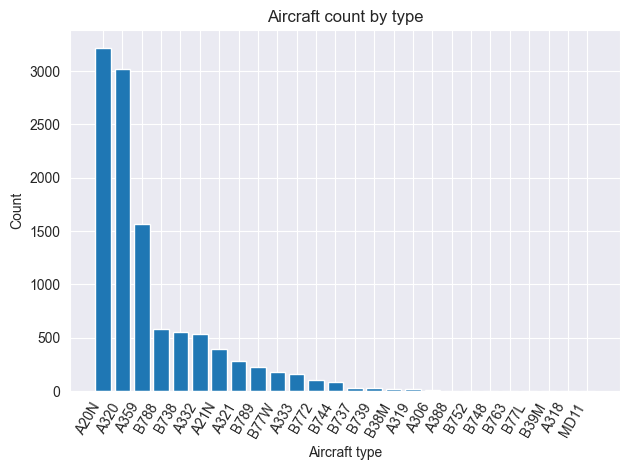

['A20N', 'A320', 'A359', 'B788', 'B738', 'A332', 'A21N', 'A321', 'B789', 'B77W', 'A333', 'B772', 'B744', 'B737', 'B739', 'B38M', 'A319', 'A306', 'A388', 'B752', 'B748', 'B763', 'B77L', 'B39M', 'A318', 'MD11']
[3220, 3023, 1571, 583, 551, 532, 393, 285, 224, 183, 156, 103, 90, 29, 28, 20, 19, 10, 4, 3, 3, 2, 2, 1, 1, 1]


In [8]:
# Get Type of Aircraft
import matplotlib.pyplot as plt

# cnt: aircraft_type + count, sorted desc
cnt = (
    df.with_columns(pl.col("aircraft_type").fill_null("Unknown"))
      .group_by("aircraft_type")
      .len()
      .sort("len", descending=True)
      .rename({"len": "count"})
)

# If many categories, keep top N (e.g., 20)
# cnt_top = cnt.head(10)
cnt_top = cnt

labels_aircraft = cnt_top.get_column("aircraft_type").to_list()
values_aircraft = cnt_top.get_column("count").to_list()

fig, ax = plt.subplots()
ax.bar(labels_aircraft, values_aircraft)
ax.set_title("Aircraft count by type")
ax.set_xlabel("Aircraft type")
ax.set_ylabel("Count")
ax.set_xticklabels(labels_aircraft, rotation=60, ha="right")
plt.tight_layout()
plt.show()

labels_aircraft = cnt.get_column("aircraft_type").to_list()
values_aircraft = cnt.get_column("count").to_list()
print(labels_aircraft)
print(values_aircraft)


In [9]:
df.null_count()

flight_date,aircraft_type,takeoff,landed,origin_icao,origin_name,destination_icao,destination_name,flight_id
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0


In [28]:
# Lit of Aircraft types which are not in OpenAPI
from openap import prop, FuelFlow
import numpy as np
import pandas as pd
available_ac = prop.available_aircraft()
labels_aircraft = cnt.get_column("aircraft_type").to_list()

csv_aircraft = pd.read_csv(os.path.join(DATA_ORIGIN, "ALL_DATA.csv"))
csv_aircraft_icao = csv_aircraft["icao"].astype(str).str.strip().tolist()  # make it a clean list
# manufacturer_name,manufacturer_company,is_variant,model,icao,class,wake,engine_type,engine_number,engine_name,engine_manufacturer,engine_model,engine_thrust,length,wingspan,tail_height,range,ceiling,max_speed,passenger_capacity,remarks,base_model
# Option 1: which labels_aircraft are NOT in the CSV?
missing_in_csv = np.setdiff1d(labels_aircraft, csv_aircraft_icao)
print("Aircraft types NOT in CSV:")
print(missing_in_csv)

# Option 2: which ones ARE in the CSV?
present_in_csv = np.intersect1d(labels_aircraft, csv_aircraft_icao)
print("Aircraft types found in CSV:")
print(present_in_csv)

print(csv_aircraft.columns)



Aircraft types NOT in CSV:
[]
Aircraft types found in CSV:
['A20N' 'A21N' 'A306' 'A318' 'A319' 'A320' 'A321' 'A332' 'A333' 'A359'
 'A388' 'B38M' 'B39M' 'B737' 'B738' 'B739' 'B744' 'B748' 'B752' 'B763'
 'B772' 'B77L' 'B77W' 'B788' 'B789' 'MD11']
Index(['manufacturer_name', 'manufacturer_company', 'is_variant', 'model',
       'icao', 'class', 'wake', 'engine_type', 'engine_number', 'engine_name',
       'engine_manufacturer', 'engine_model', 'engine_thrust', 'length',
       'wingspan', 'tail_height', 'range', 'ceiling', 'max_speed',
       'passenger_capacity', 'remarks', 'base_model'],
      dtype='object')


C:\Users\ayyildiz\AppData\Local\Temp\ipykernel_9960\4072055873.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_airport, rotation=60, ha="right")


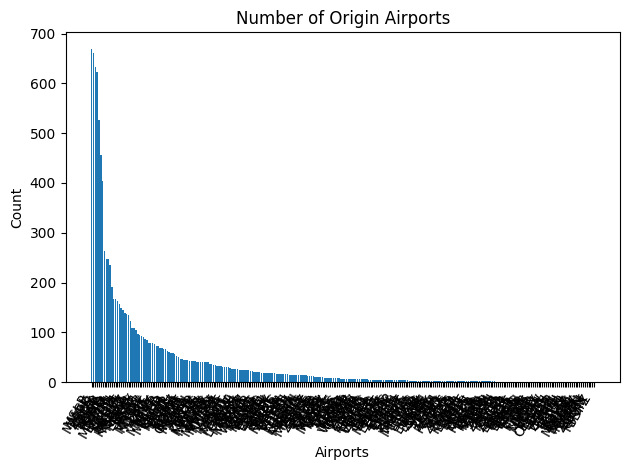

['MSLP', 'MMGL', 'KJFK', 'ZSPD', 'KBOS', 'KLAX', 'SKBO', 'KOAK', 'KMIA', 'KIAD', 'LEMD', 'MMMM', 'EHAM', 'LTFJ', 'SEGU', 'KORD', 'SEQM', 'MMLO', 'MGGT', 'KMDW', 'KMCO', 'SAEZ', 'NZAA', 'EDDP', 'RKSI', 'SKRG', 'YSSY', 'KSJC', 'MMTJ', 'MROC', 'KDFW', 'KSMF', 'LUKK', 'LIRF', 'KATL', 'KFLL', 'MMMY', 'KFAT', 'RCTP', 'MMZC', 'KSFO', 'LROP', 'NFFN', 'KMYR', 'LHBP', 'EGLL', 'KSEA', 'LGAV', 'CYYZ', 'EGPH', 'KDEN', 'OMDB', 'KONT', 'MMAS', 'KTPA', 'KBWI', 'HECA', 'LEBL', 'VIDP', 'KDTW', 'VVTS', 'MNMG', 'MMUN', 'LFPG', 'EIDW', 'EGCC', 'MMMX', 'YMML', 'MMSD', 'KRSW', 'ZLXY', 'LIPZ', 'MHLM', 'RJTT', 'KEWR', 'MMQT', 'EDDL', 'SKCL', 'LOWW', 'KCLT', 'OJAI', 'MMCU', 'KLAS', 'MMOX', 'SBGR', 'SBKP', 'WMKK', 'KBNA', 'KMSP', 'SCEL', 'KRNO', 'KCHS', 'WSSS', 'EBBR', 'EDDF', 'ZSHC', 'LTFM', 'KIAH', 'OBBI', 'EDDK', 'KMSY', 'CYUL', 'MMCS', 'ZHCC', 'FAOR', 'UAAA', 'KPDX', 'VHHH', 'LIMC', 'TJSJ', 'MMSP', 'EGGW', 'LSGG', 'MMSM', 'YBBN', 'PANC', 'MMDO', 'ZSSS', 'EFHK', 'ZSWZ', 'EGSS', 'ZUTF', 'RPLC', 'KAUS', 'CYVR',

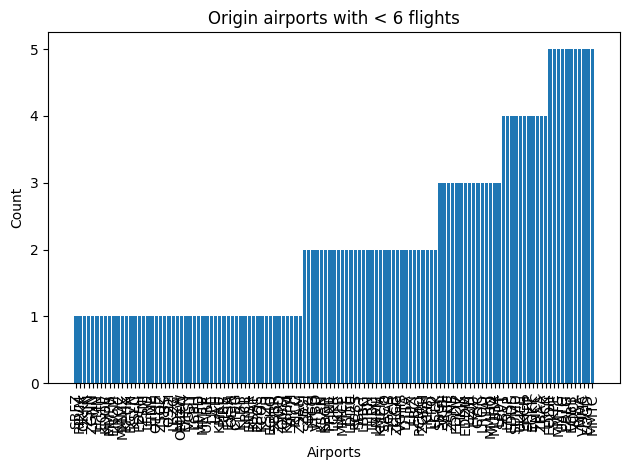

['SBFZ', 'RPVM', 'OKKK', 'ZSJN', 'ZGNN', 'LFMN', 'EGFF', 'KDOV', 'MMPB', 'ENGM', 'KROC', 'MMMZ', 'KPHX', 'EGVN', 'KSLC', 'EDFH', 'ZSNJ', 'LFRG', 'LIMF', 'OTHH', 'ZSQZ', 'LTBS', 'OSDI', 'LEZG', 'LDZA', 'OMDW', 'EHEH', 'VGSY', 'LCPH', 'LPPD', 'MMTP', 'UARR', 'LIPE', 'LATI', 'KMKE', 'RJBB', 'ESSA', 'OEJN', 'CYEG', 'KLBB', 'LRCL', 'ENBR', 'KSAT', 'EBOS', 'KCOS', 'LSZH', 'EGHQ', 'SBBR', 'ZSQD', 'OMSJ', 'KBFM', 'YPPH', 'RJCC', 'ZSAM', 'ZBSJ', 'SBEG', 'LTCG', 'VTBD', 'KSAN', 'KBGR', 'PHNL', 'LGKR', 'LKTB', 'MMCL', 'LTFE', 'LDDU', 'RCSS', 'SBCT', 'LBBG', 'LIRN', 'LLBG', 'LMML', 'KMEM', 'SACO', 'SGAS', 'LTCB', 'ZGGG', 'VGHS', 'DTTA', 'LIPX', 'EBCI', 'RCMQ', 'ZGBH', 'KPBI', 'LFPO', 'LCLK', 'SBGL', 'VCBI', 'SABE', 'ZSNB', 'EDDV', 'HKJK', 'EDDM', 'LZIB', 'LTAU', 'CYYC', 'LROD', 'LTAJ', 'MMHO', 'MUHA', 'LPPT', 'SBVT', 'LDSP', 'EDDS', 'SUMU', 'UUEE', 'EKCH', 'TTPP', 'EGKK', 'TNCC', 'ZBAA', 'LRCK', 'EDDH', 'SKPE', 'MMTG', 'UATG', 'EBLG', 'EGBB', 'VOCL', 'RJAA', 'VMMC', 'EGGD', 'MMTC']
[1, 1, 1, 1, 1,

In [160]:
# Origin Airports and Number of flights
# cnt: aircraft_type + count, sorted desc
cnt_origin = (
    df.with_columns(pl.col("origin_icao").fill_null("Unknown"))
      .group_by("origin_icao")
      .len()
      .sort("len", descending=True)
      .rename({"len": "count"})
)

# If many categories, keep top N (e.g., 20)
# cnt_top = cnt.head(10)

labels_airport = cnt_origin.get_column("origin_icao").to_list()
values_airport = cnt_origin.get_column("count").to_list()

fig, ax = plt.subplots()
ax.bar(labels_airport, values_airport)
ax.set_title("Number of Origin Airports")
ax.set_xlabel("Airports")
ax.set_ylabel("Count")
ax.set_xticklabels(labels_airport, rotation=60, ha="right")
plt.tight_layout()
plt.show()

labels_airport = cnt_origin.get_column("origin_icao").to_list()
values_airport = cnt_origin.get_column("count").to_list()
print(labels_airport)
print(values_airport)


# cnt_origin already built above
THRESH = 6
few = cnt_origin.filter(pl.col("count") < THRESH).sort("count")

labels_few = few.get_column("origin_icao").to_list()
values_few = few.get_column("count").to_list()

fig, ax = plt.subplots()
ax.bar(labels_few, values_few)
ax.set_title(f"Origin airports with < {THRESH} flights")
ax.set_xlabel("Airports")
ax.set_ylabel("Count")

# rotate existing tick labels safely
ax.tick_params(axis="x", labelrotation=90)
plt.tight_layout()
plt.show()
print(labels_few)
print(values_few)






shape: (11_037,)
Series: 'landed' [f64]
[
	12.304722
	10.492778
	13.146944
	11.200556
	12.306944
	…
	6.402222
	5.177222
	5.3175
	5.739722
	2.625
]
<built-in method sort of list object at 0x000001BE55E89580>


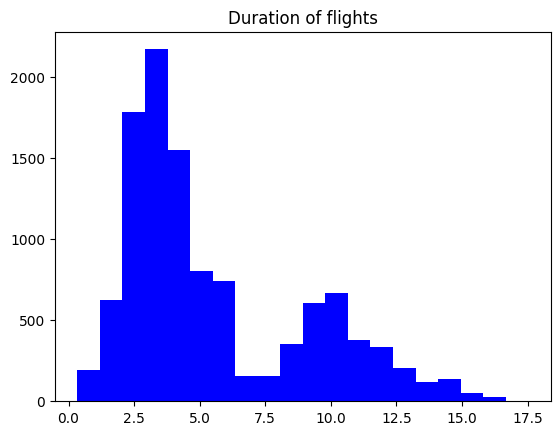

In [161]:
# Calculate flight time and plot
import datetime
takeoff = df.get_column("takeoff")
landed = df.get_column("landed")

dur_hours = (
    (df["landed"] - df["takeoff"])       # Duration dtype
      .dt.cast_time_unit("ms")           # pick a concrete unit
      .cast(pl.Float64) / 3_600_000.0    # ms -> hours
)
print(dur_hours)

list_duration = dur_hours.to_list()
print(list_duration.sort)

fig, ax = plt.subplots()

ax.hist(list_duration, 20, fill=True, color="blue")
ax.set_title('Duration of flights')

plt.show()


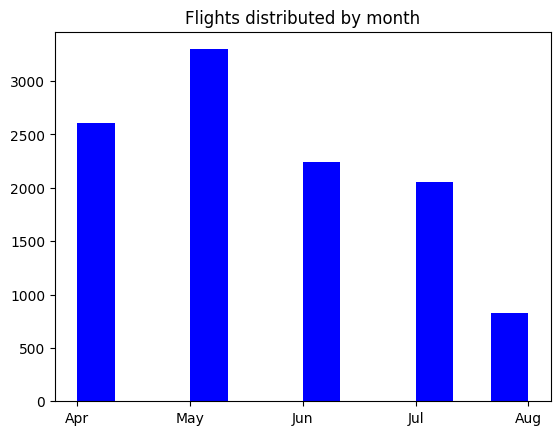

In [162]:
# Distribution of dates in months

flight_date = df.select("takeoff")

flight_date = (
     flight_date
    .with_columns(pl.col("takeoff").dt.strftime("%b").alias("month"))
    )

flight_months = flight_date.select("month")

fig, ax = plt.subplots()

ax.hist(flight_months, 12, fill=True, color="blue")
ax.set_title('Flights distributed by month')
plt.show()

plt.show()

In [168]:
# load airports
DATA_AIRPORT = os.path.join(DATA_ORIGIN, "apt.parquet")

df_apt = pl.read_parquet(DATA_AIRPORT)
ds = pl.scan_parquet("data/part-*.parquet")

df_apt.glimpse()
df_apt.count()
df_apt.null_count()

Rows: 8787
Columns: 4
$ icao      <str> 'HCAD', 'OAAK', 'OALG', 'OAMK', 'OAPJ', 'OATW', 'AGAF', 'AGAR', 'AGAT', 'AGBA'
$ longitude <f64> 46.6375, 65.206746, 69.023102, 67.848602, 67.020445, 64.42542, 160.948611, 161.979546547, 161.011002, 156.70599365234375
$ latitude  <f64> 6.095802, 36.942659, 33.9865, 32.879601, 34.391726, 33.54309, -9.191389, -9.86054358262, -8.87333, -7.912779808044434
$ elevation <i64> 1001, 900, 6333, 6600, 8800, 7370, 23, 40, None, None



icao,longitude,latitude,elevation
u32,u32,u32,u32
0,0,0,219


In [164]:
main_list = np.setdiff1d( df.select("origin_icao"), df_apt.select("icao"))
# yields the elements in `list_2` that are NOT in `list_1`
print(main_list)

[]


In [165]:
main_list = np.setdiff1d( df.select("destination_icao"), df_apt.select("icao"))
# yields the elements in `list_2` that are NOT in `list_1`
print(main_list)

[]


In [166]:
# Calculate distance between origin and destination airports

# check missing ICAO codes
need = set(pl.concat([
    df.select("origin_icao").rename({"origin_icao":"icao"}),
    df.select("destination_icao").rename({"destination_icao":"icao"})
]).drop_nulls()["icao"].to_list())

have = set(df_apt["icao"].to_list())
missing_codes = sorted(need - have)
print(missing_codes)
if missing_codes:
    raise KeyError(f"These ICAO codes are missing in df_apt: {missing_codes}")

distances = []
distances_OOD = []

# Haversine with DEGREE inputs
def haversine_km(lon1_deg, lat1_deg, lon2_deg, lat2_deg):
    R = 6371.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1_deg, lat1_deg, lon2_deg, lat2_deg])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Loop with proper filtering + scalar extraction
for row in df.select(["origin_icao", "destination_icao"]).iter_rows(named=True):
    origin = row["origin_icao"]
    dest   = row["destination_icao"]
    if origin is None or dest is None:
        raise ValueError(f"Null ICAO in row: origin={origin}, dest={dest}")

    apt_or   = df_apt.filter(pl.col("icao") == origin)
    apt_dest = df_apt.filter(pl.col("icao") == dest)

    if apt_or.is_empty():
        raise KeyError(f"Origin airport not found in df_apt: {origin}")
    if apt_dest.is_empty():
        raise KeyError(f"Destination airport not found in df_apt: {dest}")

    lon1 = float(apt_or.get_column("longitude").item())
    lat1 = float(apt_or.get_column("latitude").item())
    lon2 = float(apt_dest.get_column("longitude").item())
    lat2 = float(apt_dest.get_column("latitude").item())

    distance_km = haversine_km(lon1, lat1, lon2, lat2)
    if distance_km < 150:
        print(f"{origin} -> {dest}")
        print(distance_km)
        distances_OOD.append([distance_km, origin, dest])
    else:
        distances.append(distance_km)
    # print(origin, dest, lon1, lat1, lon2,lat2, distance_km)
print(distances_OOD)


[]
SABE -> SAEZ
31.24100237537165
LKTB -> LKTB
0.0
VTBD -> VTBS
29.852777454485693
LMML -> LMML
0.0
LMML -> LMML
0.0
KCOS -> KDEN
117.43509694885212
[[np.float64(31.24100237537165), 'SABE', 'SAEZ'], [np.float64(0.0), 'LKTB', 'LKTB'], [np.float64(29.852777454485693), 'VTBD', 'VTBS'], [np.float64(0.0), 'LMML', 'LMML'], [np.float64(0.0), 'LMML', 'LMML'], [np.float64(117.43509694885212), 'KCOS', 'KDEN']]


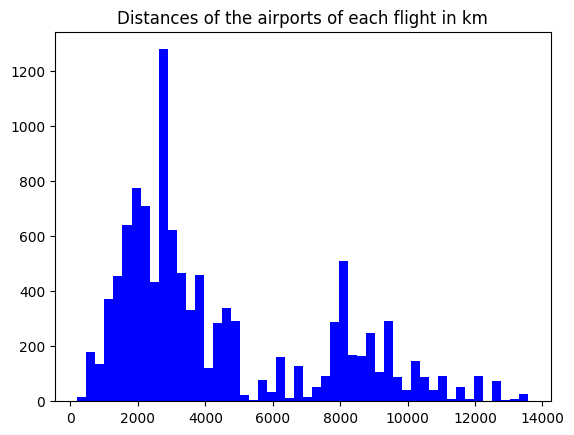

In [167]:
# print distances distribution
fig, ax = plt.subplots()

ax.hist(distances, 50, fill=True, color="blue")
ax.set_title('Distances of the airports of each flight in km')

plt.show()